<a href="https://colab.research.google.com/github/minurasam/Brain-Tumor-Detection-CNN/blob/main/MRI_Brain_Tumor_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

All BraTS multimodal scans are available as NIfTI files (.nii.gz) and describe a) native (T1) and b) post-contrast T1-weighted (T1Gd), c) T2-weighted (T2), and d) T2 Fluid Attenuated Inversion Recovery (T2-FLAIR) volumes.

Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1).
You can look at the 3d data projection [here](https://www.kaggle.com/polomarco/brats20logs/) or [here](https://www.youtube.com/watch?v=0nliIOj2WVQ).

# Formulation of the problem:
+ 1. Each pixel must be labeled “1” if it is part of one of the classes (NCR/NET — label 1, ED — label 2, ET — label 4), and “0” if not.
+ 2. Make a prediction of age and survival days for each unique identifier in the data.

# Solution
+ 1. For automatic segmentation we will use Unet3d
+ 2. To predict the age and number of days of survival: first, we will train the auto-encoder to scale the space from 4 * 240 * 240 * 150 to 512, and then extract the statistical values, ​​and hidden representations for each identifier in the data encoded by the pre-trained auto-encoder and based on this tabular data we will train SVR.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 5.4 MB/s 


In [6]:
!pip install nilearn

     |████████████████████████████████| 10.0 MB 1.3 MB/s 


In [7]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 5.3 MB/s 
     |████████████████████████████████| 948 kB 38.3 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=2eaefbcb1d4e14c6f88be22227c6b51fe4be0bb41ecf9e29b907aeab1e4418fc
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [8]:
from tqdm import tqdm
import os
import time
import cv2
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib
import pydicom as pdm
import nilearn as nl
import nilearn.plotting as nlplt
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output
from IPython.display import YouTubeVideo

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss


# import albumentations as A
from albumentations import Compose, HorizontalFlip
# from albumentations.pytorch import ToTensor, ToTensorV2 

import warnings
warnings.simplefilter("ignore")

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [9]:
sample_filename = '/content/drive/MyDrive/Research Experiments/Training/BraTS20_Training_001_flair.nii'
sample_filename_mask = '/content/drive/MyDrive/Research Experiments/Training/BraTS20_Training_001_seg.nii'

sample_img = nib.load(sample_filename)
sample_img = np.asanyarray(sample_img.dataobj)
sample_img = np.rot90(sample_img)
sample_mask = nib.load(sample_filename_mask)
sample_mask = np.asanyarray(sample_mask.dataobj)
sample_mask = np.rot90(sample_mask)
print("img shape ->", sample_img.shape)
print("mask shape ->", sample_mask.shape)
print("mask size ->", sample_img.size)

img shape -> (240, 240, 155)
mask shape -> (240, 240, 155)
mask size -> 8928000


In [10]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [11]:
sample_filename2 = '/content/drive/MyDrive/Research Experiments/Training/BraTS20_Training_001_t1.nii'
sample_img2 = nib.load(sample_filename2)
sample_img2 = np.asanyarray(sample_img2.dataobj)
sample_img2  = np.rot90(sample_img2)

sample_filename3 = '/content/drive/MyDrive/Research Experiments/Training/BraTS20_Training_001_t2.nii'
sample_img3 = nib.load(sample_filename3)
sample_img3 = np.asanyarray(sample_img3.dataobj)
sample_img3  = np.rot90(sample_img3)

sample_filename4 = '/content/drive/MyDrive/Research Experiments/Training/BraTS20_Training_001_t1ce.nii'
sample_img4 = nib.load(sample_filename4)
sample_img4 = np.asanyarray(sample_img4.dataobj)
sample_img4  = np.rot90(sample_img4)

mask_WT = sample_mask.copy()
mask_WT[mask_WT == 1] = 1
mask_WT[mask_WT == 2] = 1
mask_WT[mask_WT == 4] = 1

mask_TC = sample_mask.copy()
mask_TC[mask_TC == 1] = 1
mask_TC[mask_TC == 2] = 0
mask_TC[mask_TC == 4] = 1

mask_ET = sample_mask.copy()
mask_ET[mask_ET == 1] = 0
mask_ET[mask_ET == 2] = 0
mask_ET[mask_ET == 4] = 1

In [12]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



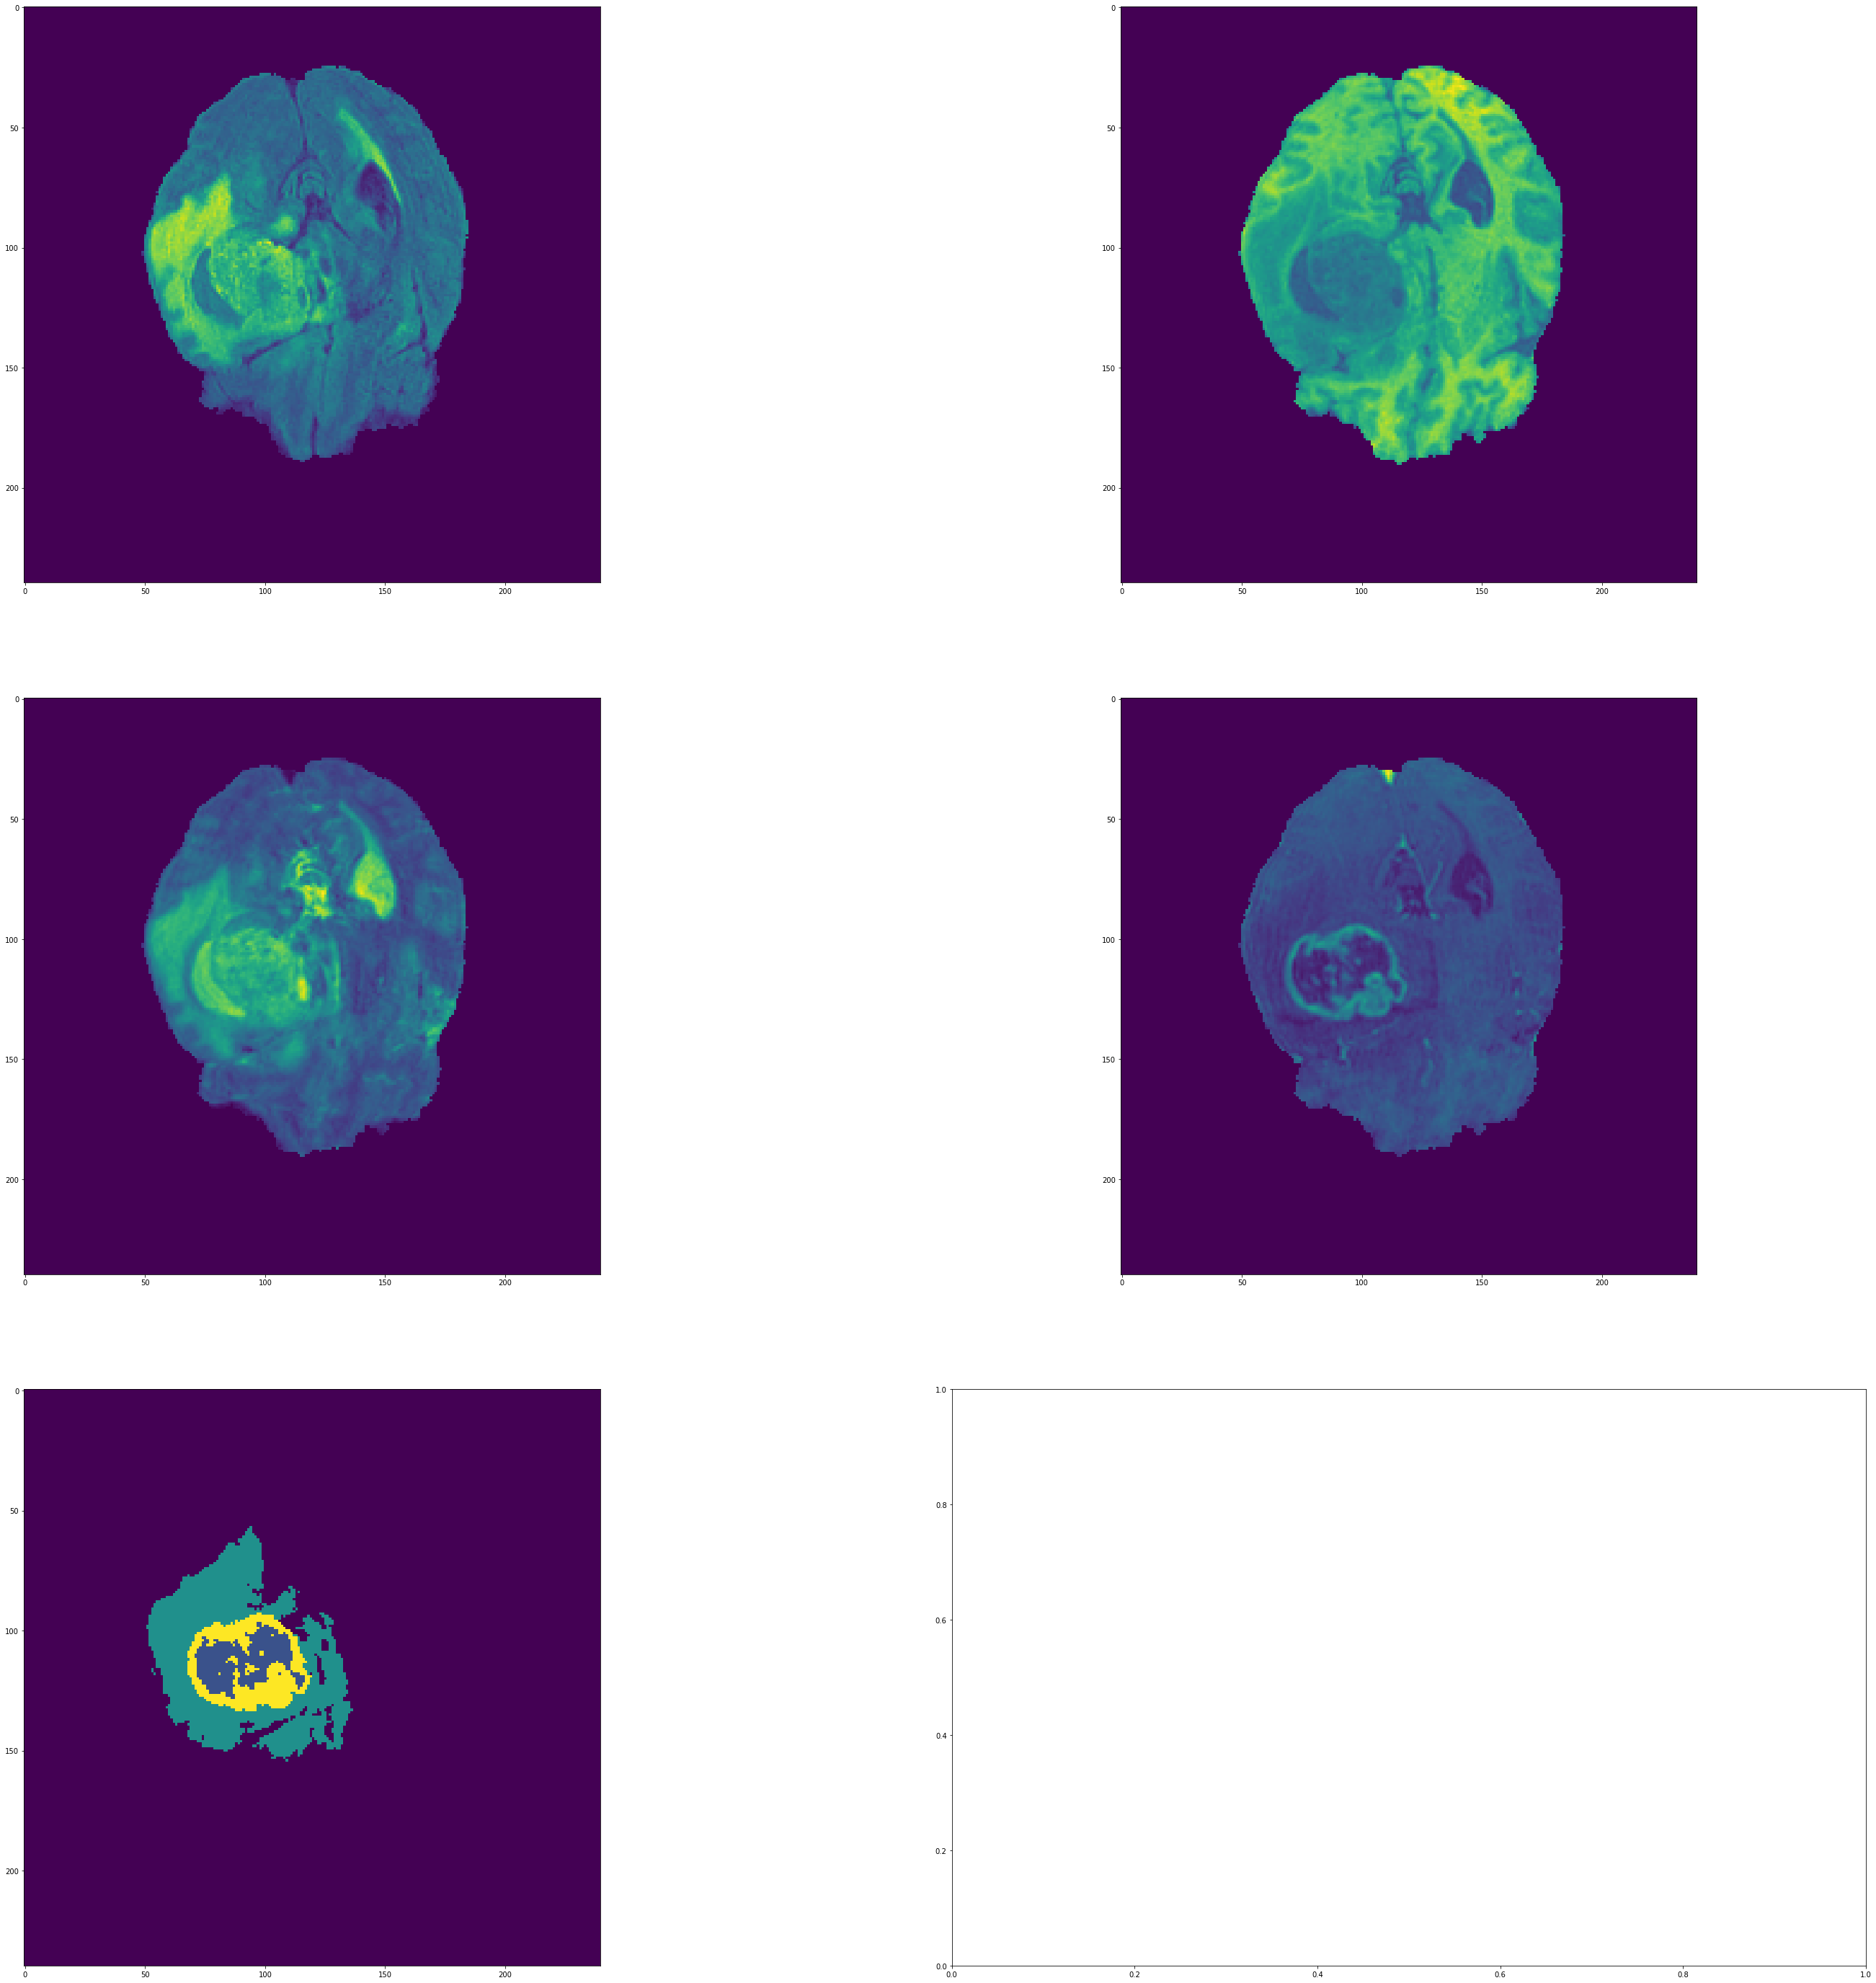

In [13]:
img1 = sample_img[:,:,64]
seg = sample_mask[:,:,65]
img2 = sample_img2[:,:,65]
img3 = sample_img3[:,:,65]
img4 = sample_img4[:,:,65]
f, axarr = plt.subplots(3,2, figsize=(50, 50))
axarr[0,0].imshow(img1)
axarr[0,1].imshow(img2)
axarr[1,0].imshow(img3)
axarr[1,1].imshow(img4)
axarr[2,0].imshow(seg)

In [14]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [15]:
# f, axarr = plt.subplots(16,10, figsize=(100, 200))
# x=30
# for i in range(16):
#   for j in range(10):
#     img = sample_img4[x,:,:]
#     x=x+1
#     axarr[i,j].imshow(img)
#     if x==155:
#       break


### What's the data looks like ?

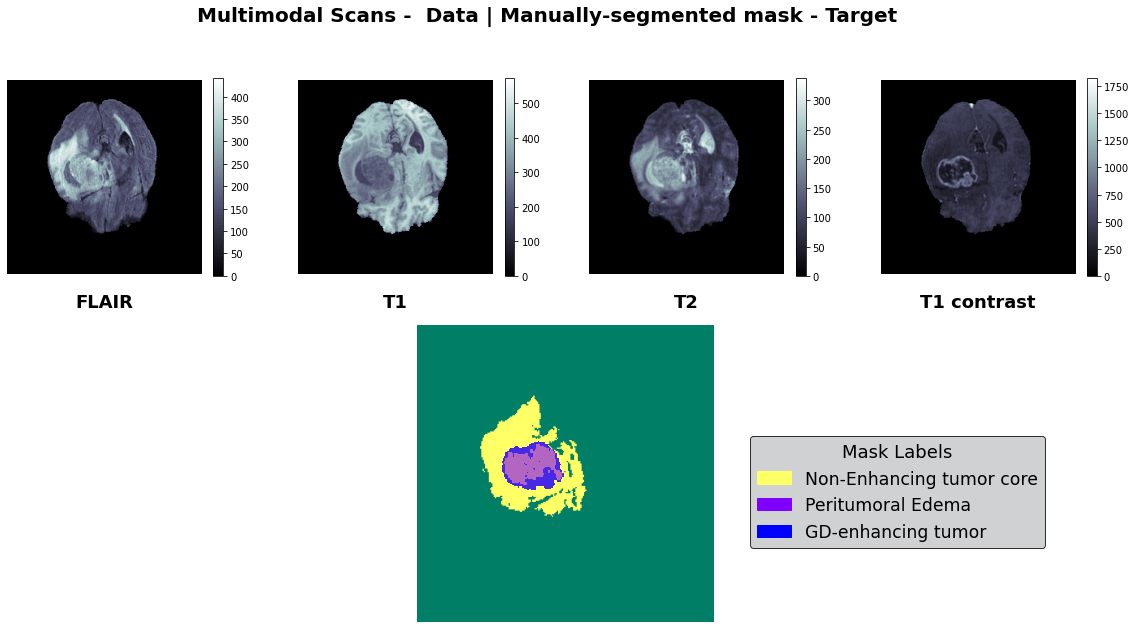

In [16]:
# https://matplotlib.org/3.3.2/gallery/images_contours_and_fields/plot_streamplot.html#sphx-glr-gallery-images-contours-and-fields-plot-streamplot-py
# https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib
fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 1.5])

#  Varying density along a streamline
ax0 = fig.add_subplot(gs[0, 0])
flair = ax0.imshow(sample_img[:,:,65], cmap='bone')
ax0.set_title("FLAIR", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(flair)

#  Varying density along a streamline
ax1 = fig.add_subplot(gs[0, 1])
t1 = ax1.imshow(sample_img2[:,:,65], cmap='bone')
ax1.set_title("T1", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1)

#  Varying density along a streamline
ax2 = fig.add_subplot(gs[0, 2])
t2 = ax2.imshow(sample_img3[:,:,65], cmap='bone')
ax2.set_title("T2", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t2)

#  Varying density along a streamline
ax3 = fig.add_subplot(gs[0, 3])
t1ce = ax3.imshow(sample_img4[:,:,65], cmap='bone')
ax3.set_title("T1 contrast", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1ce)

#  Varying density along a streamline
ax4 = fig.add_subplot(gs[1, 1:3])

#ax4.imshow(np.ma.masked_where(mask_WT[:,:,65]== False,  mask_WT[:,:,65]), cmap='summer', alpha=0.6)
l1 = ax4.imshow(mask_WT[:,:,65], cmap='summer',)
l2 = ax4.imshow(np.ma.masked_where(mask_TC[:,:,65]== False,  mask_TC[:,:,65]), cmap='rainbow', alpha=0.6)
l3 = ax4.imshow(np.ma.masked_where(mask_ET[:,:,65] == False, mask_ET[:,:,65]), cmap='winter', alpha=0.6)

ax4.set_title("", fontsize=20, weight='bold', y=-0.1)

_ = [ax.set_axis_off() for ax in [ax0,ax1,ax2,ax3, ax4]]

colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
labels = ['Non-Enhancing tumor core', 'Peritumoral Edema ', 'GD-enhancing tumor']
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 'xx-large',
           title='Mask Labels', title_fontsize=18, edgecolor="black",  facecolor='#c5c6c7')

plt.suptitle("Multimodal Scans -  Data | Manually-segmented mask - Target", fontsize=20, weight='bold')

fig.savefig("data_sample.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("data_sample.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [17]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



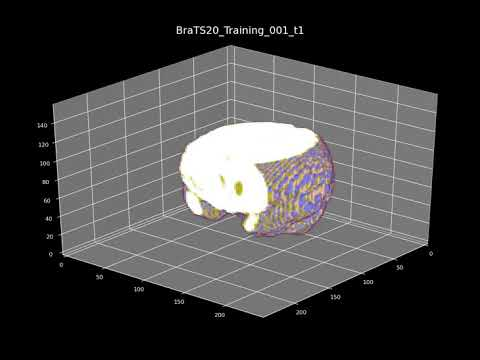

In [18]:
YouTubeVideo('nrmizEvG8aM', width=600, height=400)

helper classes and functions

In [19]:
class Image3dToGIF3d:
    """
    Displaying 3D images in 3d axes.
    Parameters:
        img_dim: shape of cube for resizing.
        figsize: figure size for plotting in inches.
    """
    def __init__(self, 
                 img_dim: tuple = (55, 55, 55),
                 figsize: tuple = (15, 10),
                 binary: bool = False,
                 normalizing: bool = True,
                ):
        """Initialization."""
        self.img_dim = img_dim
        print(img_dim)
        self.figsize = figsize
        self.binary = binary
        self.normalizing = normalizing

    def _explode(self, data: np.ndarray):
        """
        Takes: array and return an array twice as large in each dimension,
        with an extra space between each voxel.
        """
        shape_arr = np.array(data.shape)
        size = shape_arr[:3] * 2 - 1
        exploded = np.zeros(np.concatenate([size, shape_arr[3:]]),
                            dtype=data.dtype)
        exploded[::2, ::2, ::2] = data
        return exploded

    def _expand_coordinates(self, indices: np.ndarray):
        x, y, z = indices
        x[1::2, :, :] += 1
        y[:, 1::2, :] += 1
        z[:, :, 1::2] += 1
        return x, y, z
    
    def _normalize(self, arr: np.ndarray):
        """Normilize image value between 0 and 1."""
        arr_min = np.min(arr)
        return (arr - arr_min) / (np.max(arr) - arr_min)

    
    def _scale_by(self, arr: np.ndarray, factor: int):
        """
        Scale 3d Image to factor.
        Parameters:
            arr: 3d image for scalling.
            factor: factor for scalling.
        """
        mean = np.mean(arr)
        return (arr - mean) * factor + mean
    
    def get_transformed_data(self, data: np.ndarray):
        """Data transformation: normalization, scaling, resizing."""
        if self.binary:
            resized_data = resize(data, self.img_dim, preserve_range=True)
            return np.clip(resized_data.astype(np.uint8), 0, 1).astype(np.float32)
            
        norm_data = np.clip(self._normalize(data)-0.1, 0, 1) ** 0.4
        scaled_data = np.clip(self._scale_by(norm_data, 2) - 0.1, 0, 1)
        resized_data = resize(scaled_data, self.img_dim, preserve_range=True)
        
        return resized_data
    
    def plot_cube(self,
                  cube,
                  title: str = '', 
                  init_angle: int = 0,
                  make_gif: bool = False,
                  path_to_save: str = 'filename.gif'
                 ):
        """
        Plot 3d data.
        Parameters:
            cube: 3d data
            title: title for figure.
            init_angle: angle for image plot (from 0-360).
            make_gif: if True create gif from every 5th frames from 3d image plot.
            path_to_save: path to save GIF file.
            """
        if self.binary:
            facecolors = cm.winter(cube)
            print("binary")
        else:
            if self.normalizing:
                cube = self._normalize(cube)
            facecolors = cm.gist_stern(cube)
            print("not binary")
            
        facecolors[:,:,:,-1] = cube
        facecolors = self._explode(facecolors)

        filled = facecolors[:,:,:,-1] != 0
        x, y, z = self._expand_coordinates(np.indices(np.array(filled.shape) + 1))

        with plt.style.context("dark_background"):

            fig = plt.figure(figsize=self.figsize)
            ax = fig.gca(projection='3d')

            ax.view_init(30, init_angle)
            ax.set_xlim(right = self.img_dim[0] * 2)
            ax.set_ylim(top = self.img_dim[1] * 2)
            ax.set_zlim(top = self.img_dim[2] * 2)
            ax.set_title(title, fontsize=18, y=1.05)

            ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)

            if make_gif:
                images = []
                for angle in tqdm(range(0, 360, 5)):
                    ax.view_init(30, angle)
                    fname = str(angle) + '.png'

                    plt.savefig(fname, dpi=120, format='png', bbox_inches='tight')
                    images.append(imageio.imread(fname))
                    #os.remove(fname)
                imageio.mimsave(path_to_save, images)
                plt.close()

            else:
                plt.show()

                
class ShowResult:
  
    def mask_preprocessing(self, mask):
        """
        Test.
        """
        mask = mask.squeeze().cpu().detach().numpy()
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        mask_WT = np.rot90(montage(mask[0]))
        mask_TC = np.rot90(montage(mask[1]))
        mask_ET = np.rot90(montage(mask[2]))

        return mask_WT, mask_TC, mask_ET

    def image_preprocessing(self, image):
        """
        Returns image flair as mask for overlaping gt and predictions.
        """
        image = image.squeeze().cpu().detach().numpy()
        image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 2, 1))
        flair_img = np.rot90(montage(image[0]))
        return flair_img
    
    def plot(self, image, ground_truth, prediction):
        image = self.image_preprocessing(image)
        gt_mask_WT, gt_mask_TC, gt_mask_ET = self.mask_preprocessing(ground_truth)
        pr_mask_WT, pr_mask_TC, pr_mask_ET = self.mask_preprocessing(prediction)
        
        fig, axes = plt.subplots(1, 2, figsize = (35, 30))
    
        [ax.axis("off") for ax in axes]
        axes[0].set_title("Ground Truth", fontsize=35, weight='bold')
        axes[0].imshow(image, cmap ='bone')
        axes[0].imshow(np.ma.masked_where(gt_mask_WT == False, gt_mask_WT),
                  cmap='cool_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_TC == False, gt_mask_TC),
                  cmap='autumn_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_ET == False, gt_mask_ET),
                  cmap='autumn', alpha=0.6)

        axes[1].set_title("Prediction", fontsize=35, weight='bold')
        axes[1].imshow(image, cmap ='bone')
        axes[1].imshow(np.ma.masked_where(pr_mask_WT == False, pr_mask_WT),
                  cmap='cool_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_TC == False, pr_mask_TC),
                  cmap='autumn_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_ET == False, pr_mask_ET),
                  cmap='autumn', alpha=0.6)

        plt.tight_layout()
        
        plt.show()
        
#show_result = ShowResult()
#show_result.plot(data['image'], data['mask'], data['mask'])


def merging_two_gif(path1: str, path2: str, name_to_save: str):
    """
    Merging GIFs side by side.
    Parameters:
        path1: path to gif with ground truth.
        path2: path to gif with prediction.
        name_to_save: name for saving new GIF.
    """
    #https://stackoverflow.com/questions/51517685/combine-several-gif-horizontally-python
    #Create reader object for the gif
    gif1 = imageio.get_reader(path1)
    gif2 = imageio.get_reader(path2)

    #If they don't have the same number of frame take the shorter
    number_of_frames = min(gif1.get_length(), gif2.get_length()) 

    #Create writer object
    new_gif = imageio.get_writer(name_to_save)

    for frame_number in range(number_of_frames):
        img1 = gif1.get_next_data()
        img2 = gif2.get_next_data()
        #here is the magic
        new_image = np.hstack((img1, img2))
        new_gif.append_data(new_image)

    gif1.close()
    gif2.close()    
    new_gif.close()
    
#merging_two_gif('BraTS20_Training_001_flair_3d.gif',
#                'BraTS20_Training_001_flair_3d.gif', 
#                'result.gif')

def get_all_csv_file(root: str) -> list:
    """Extraction all unique ids from file names."""
    ids = []
    for dirname, _, filenames in os.walk(root):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            if path.endswith(".csv"):
                ids.append(path) 
    ids = list(set(filter(None, ids)))
    print(f"Extracted {len(ids)} csv files.")
    return ids

#csv_paths = get_all_csv_file("../input/brats20-dataset-training-validation/BraTS2020_TrainingData")

In [20]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [21]:
class GlobalConfig:
    root_dir = '/content/drive/MyDrive/Research Experiments/'
    train_root_dir = '/content/drive/MyDrive/Research Experiments/Training/'
    test_root_dir = '/content/drive/MyDrive/Research Experiments/Validation/'
    path_to_csv = './train_data.csv'
    pretrained_model_path = '/content/drive/MyDrive/Research Experiments/unet/last_epoch_model.pth'
    train_logs_path = '/content/drive/MyDrive/Research Experiments/unet/train_log.csv'
    ae_pretrained_model_path = '/content/drive/MyDrive/Research Experiments/ae/autoencoder_best_model.pth'
    tab_data = '/content/drive/MyDrive/Research Experiments/data/df_with_voxel_stats_and_latent_features.csv'
    seed = 55
    
def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = GlobalConfig()
seed_everything(config.seed)

Data Preprocessing

In [22]:
survival_info_df = pd.read_csv('/content/drive/MyDrive/Research Experiments/Training/survival_info.csv')
name_mapping_df = pd.read_csv('/content/drive/MyDrive/Research Experiments/Training/name_mapping.csv')

name_mapping_df.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis=1, inplace=True) 


df = survival_info_df.merge(name_mapping_df, on="Brats20ID", how="right")

paths = []
for _, row  in df.iterrows():
    
    id_ = row['Brats20ID']
    phase = id_.split("_")[-2]
    
    if phase == 'Training':
        path = os.path.join(config.train_root_dir)
    else:
        path = os.path.join(config.test_root_dir)
    paths.append(path)
    
df['path'] = paths

#split data on train, test, split
#train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=69, shuffle=True)
#train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

train_data = df.loc[df['Age'].notnull()].reset_index(drop=True)
train_data["Age_rank"] =  train_data["Age"] // 10 * 10
train_data = train_data.loc[train_data['Brats20ID'] != 'BraTS20_Training_355'].reset_index(drop=True, )

skf = StratifiedKFold(
    n_splits=7, random_state=config.seed, shuffle=True
)
for i, (train_index, val_index) in enumerate(
        skf.split(train_data, train_data["Age_rank"])
        ):
        train_data.loc[val_index, "fold"] = i

train_df = train_data.loc[train_data['fold'] != 0].reset_index(drop=True)
val_df = train_data.loc[train_data['fold'] == 0].reset_index(drop=True)

test_df = df.loc[~df['Age'].notnull()].reset_index(drop=True)
print("train_df ->", train_df.shape, "val_df ->", val_df.shape, "test_df ->", test_df.shape)
train_data.to_csv("train_data.csv", index=False)

train_df -> (201, 12) val_df -> (34, 12) test_df -> (133, 10)


# Dataset DataLoader

In [23]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [24]:
class BratsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str="test", is_resize: bool=False):
        self.df = df
        self.phase = phase
        self.augmentations = get_augmentations(phase)
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        self.is_resize = is_resize
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        id_ = self.df.loc[idx, 'Brats20ID']
        root_path = self.df.loc[self.df['Brats20ID'] == id_]['path'].values[0]
        # load all modalities
        images = []
        for data_type in self.data_types:
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)#.transpose(2, 0, 1)
            
            if self.is_resize:
                img = self.resize(img)
    
            img = self.normalize(img)
            images.append(img)
        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))
        
        if self.phase != "test":
            mask_path =  os.path.join(root_path, id_ + "_seg.nii")
            mask = self.load_img(mask_path)
            
            if self.is_resize:
                mask = self.resize(mask)
                mask = np.clip(mask.astype(np.uint8), 0, 1).astype(np.float32)
                mask = np.clip(mask, 0, 1)
            mask = self.preprocess_mask_labels(mask)
    
            augmented = self.augmentations(image=img.astype(np.float32), 
                                           mask=mask.astype(np.float32))
            
            img = augmented['image']
            mask = augmented['mask']
    
        
            return {
                "Id": id_,
                "image": img,
                "mask": mask,
            }
        
        return {
            "Id": id_,
            "image": img,
        }
    
    def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data
    
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)
    
    def resize(self, data: np.ndarray):
        data = resize(data, (78, 120, 120), preserve_range=True)
        return data
    
    def preprocess_mask_labels(self, mask: np.ndarray):

        mask_WT = mask.copy()
        mask_WT[mask_WT == 1] = 1
        mask_WT[mask_WT == 2] = 1
        mask_WT[mask_WT == 4] = 1

        mask_TC = mask.copy()
        mask_TC[mask_TC == 1] = 1
        mask_TC[mask_TC == 2] = 0
        mask_TC[mask_TC == 4] = 1

        mask_ET = mask.copy()
        mask_ET[mask_ET == 1] = 0
        mask_ET[mask_ET == 2] = 0
        mask_ET[mask_ET == 4] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET])
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        return mask

        

In [25]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [26]:
def get_augmentations(phase):
    list_transforms = []
    
    list_trfms = Compose(list_transforms)
    return list_trfms


def get_dataloader(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    num_workers: int = 4,
):
    '''Returns: dataloader for the model training'''
    df = pd.read_csv(path_to_csv)
    
    train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
    val_df = df.loc[df['fold'] == fold].reset_index(drop=True)

    df = train_df if phase == "train" else val_df
    dataset = dataset(df, phase)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )
    return dataloader

In [27]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [28]:
dataloader = get_dataloader(dataset=BratsDataset, path_to_csv='./train_data.csv', phase='valid', fold=0)
len(dataloader)

34

In [29]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [30]:
data = next(iter(dataloader))
data['Id'], data['image'].shape, data['mask'].shape

(['BraTS20_Training_162'],
 torch.Size([1, 4, 155, 240, 240]),
 torch.Size([1, 3, 155, 240, 240]))

In [31]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Num uniq Image values : 398
Min/Max Image values: 0.0 1.0
Num uniq Mask values: (array([0., 1.], dtype=float32), array([8820672,  107328]))


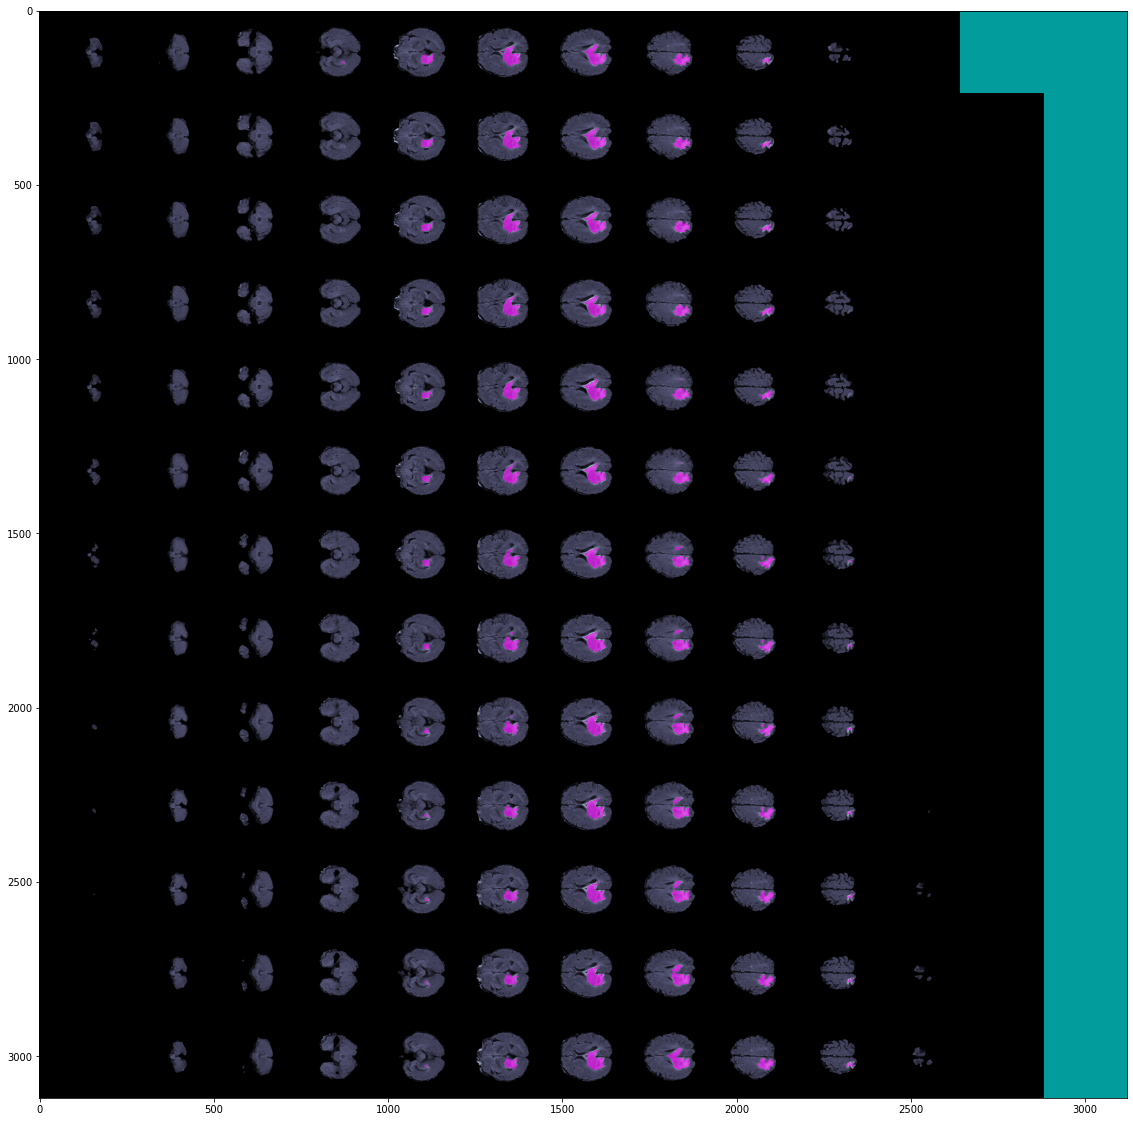

In [32]:
img_tensor = data['image'].squeeze()[0].cpu().detach().numpy() 
mask_tensor = data['mask'].squeeze()[0].squeeze().cpu().detach().numpy()
print("Num uniq Image values :", len(np.unique(img_tensor, return_counts=True)[0]))
print("Min/Max Image values:", img_tensor.min(), img_tensor.max())
print("Num uniq Mask values:", np.unique(mask_tensor, return_counts=True))

image = np.rot90(montage(img_tensor))
mask = np.rot90(montage(mask_tensor)) 

fig, ax = plt.subplots(1, 1, figsize = (20, 20))
ax.imshow(image, cmap ='bone')
ax.imshow(np.ma.masked_where(mask == False, mask),
           cmap='cool', alpha=0.6)

# Metric and Loss

In [33]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [34]:
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Dice score for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: dice score aka f1.
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Jaccard index for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: jaccard score aka iou."
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


class Meter:
    '''factory for storing and updating iou and dice scores.'''
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []
    
    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        """
        Takes: logits from output model and targets,
        calculates dice and iou scores, and stores them in lists.
        """
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)
        
        self.dice_scores.append(dice)
        self.iou_scores.append(iou)
    
    def get_metrics(self) -> np.ndarray:
        """
        Returns: the average of the accumulated dice and iou scores.
        """
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou


class DiceLoss(nn.Module):
    """Calculate dice loss."""
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps
        
    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)
        
        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score
        
        
class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, 
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)
        
        return bce_loss + dice_loss
    
# helper functions for testing.  
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Dice score for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with dice scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)
                
    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Jaccard index for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with jaccard scores for each class."
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

# 3DUnet

In [35]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [36]:
class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)
          )

    def forward(self,x):
        return self.double_conv(x)

    
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)

    
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

    
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNet3d(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 8 * n_channels)

        self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 2 * n_channels)
        self.dec3 = Up(4 * n_channels, n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        mask = self.dec1(x5, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)
        return mask

In [37]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Trainer

In [41]:
class Trainer:
    """
    Factory for training proccess.
    Args:
        display_plot: if True - plot train history after each epoch.
        net: neural network for mask prediction.
        criterion: factory for calculating objective loss.
        optimizer: optimizer for weights updating.
        phases: list with train and validation phases.
        dataloaders: dict with data loaders for train and val phases.
        path_to_csv: path to csv file.
        meter: factory for storing and updating metrics.
        batch_size: data batch size for one step weights updating.
        num_epochs: num weights updation for all data.
        accumulation_steps: the number of steps after which the optimization step can be taken
                    (https://www.kaggle.com/c/understanding_cloud_organization/discussion/105614).
        lr: learning rate for optimizer.
        scheduler: scheduler for control learning rate.
        losses: dict for storing lists with losses for each phase.
        jaccard_scores: dict for storing lists with jaccard scores for each phase.
        dice_scores: dict for storing lists with dice scores for each phase.
    """
    def __init__(self,
                 net: nn.Module,
                 dataset: torch.utils.data.Dataset,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 fold: int,
                 num_epochs: int,
                 path_to_csv: str,
                 display_plot: bool = True,
                ):

        """Initialization."""
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs

        self.dataloaders = {
            phase: get_dataloader(
                dataset = dataset,
                path_to_csv = path_to_csv,
                phase = phase,
                fold = fold,
                batch_size = batch_size,
                num_workers = 4
            )
            for phase in self.phases
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}
         
    def _compute_loss_and_outputs(self,
                                  images: torch.Tensor,
                                  targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images)
        loss = self.criterion(logits, targets)
        return loss, logits
        
    def _do_epoch(self, epoch: int, phase: str):
        print(f"{phase} epoch: {epoch} | time: {time.strftime('%H:%M:%S')}")

        
        if phase == "train":
            self.net.train()
        else:
            with torch.no_grad():
                self.net.eval()
        
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        for itr, data_batch in enumerate(dataloader):
            images, targets = data_batch['image'], data_batch['mask']
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(),
                         targets.detach().cpu()
                        )
            
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()
        
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        return epoch_loss
        
    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()
                
            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")
            print()
        self._save_train_history()
            
    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,
            
            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]} 
            """, 
                  
            f"""
            train jaccard score {self.jaccard_scores['train'][-1]}
            val jaccard score {self.jaccard_scores['val'][-1]}
            """,
        ]
        
        clear_output(True)
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")
                
            plt.tight_layout()
            plt.show()
            
    def load_predtrain_model(self,
                             state_path: str):
        self.net.load_state_dict(torch.load(state_path, map_location=torch.device('cpu')))
        print("Predtrain model loaded")
        
    def _save_train_history(self):
        """writing model weights and training logs to files."""
        torch.save(self.net.state_dict(),
                   f"last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i] 
                     for i in list(range(len(logs_))) 
                     for key in logs_[i]
                    ]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv("train_log.csv", index=False)

In [42]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



training process

In [43]:
nodel = UNet3d(in_channels=4, n_classes=3, n_channels=24)

In [44]:
trainer = Trainer(net=nodel,
                  dataset=BratsDataset,
                  criterion=BCEDiceLoss(),
                  lr=5e-4,
                  accumulation_steps=1,
                  batch_size=1,
                  fold=0,
                  num_epochs=1,
                  path_to_csv = config.path_to_csv,
                  )

if config.pretrained_model_path is not None:
    trainer.load_predtrain_model(config.pretrained_model_path)
    
    # if need - load the logs.      
    train_logs = pd.read_csv(config.train_logs_path)
    trainer.losses["train"] =  train_logs.loc[:, "train_loss"].to_list()
    trainer.losses["val"] =  train_logs.loc[:, "val_loss"].to_list()
    trainer.dice_scores["train"] = train_logs.loc[:, "train_dice"].to_list()
    trainer.dice_scores["val"] = train_logs.loc[:, "val_dice"].to_list()
    trainer.jaccard_scores["train"] = train_logs.loc[:, "train_jaccard"].to_list()
    trainer.jaccard_scores["val"] = train_logs.loc[:, "val_jaccard"].to_list()

device: cpu
Predtrain model loaded


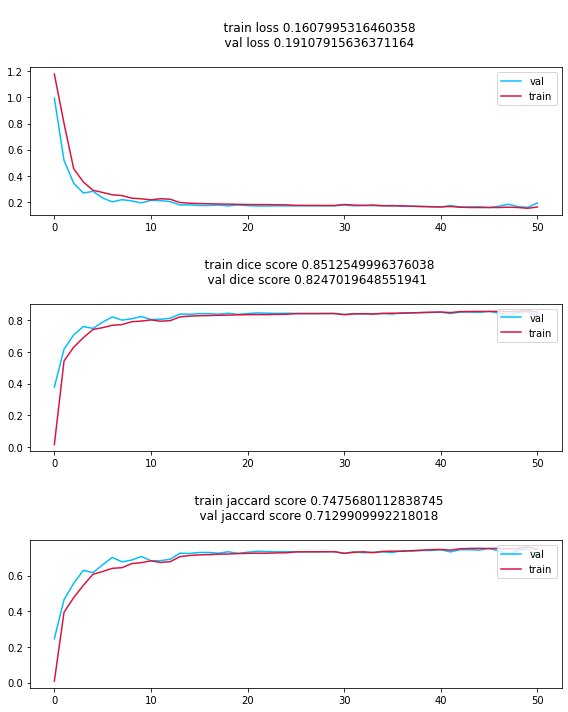


####################
Saved new checkpoint
####################


CPU times: user 16h 57min 51s, sys: 8min 53s, total: 17h 6min 44s
Wall time: 56min 42s


In [45]:
%%time
trainer.run()

# Experiments and Results

In [46]:
def compute_scores_per_classes(model,
                               dataloader,
                               classes):
    """
    Compute Dice and Jaccard coefficients for each class.
    Params:
        model: neural net for make predictions.
        dataloader: dataset object to load data from.
        classes: list with classes.
        Returns: dictionaries with dice and jaccard coefficients for each class for each slice.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            imgs, targets = data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            
            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes


In [47]:
val_dataloader = get_dataloader(BratsDataset, 'train_data.csv', phase='valid', fold=0)
len(dataloader)

34

In [48]:
nodel.eval();

In [49]:
%%time
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(
    nodel, val_dataloader, ['WT', 'TC', 'ET']
    )

CPU times: user 32min 27s, sys: 1min 36s, total: 34min 3s
Wall time: 2min 18s


In [50]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard', 
                                      'TC dice', 'TC jaccard', 
                                      'ET dice', 'ET jaccard']]
val_metics_df.sample(5)

,WT dice,WT jaccard,TC dice,TC jaccard,ET dice,ET jaccard
4,0.402631,0.252059,0.664573,0.497648,0.850488,0.739869
9,0.855935,0.748152,0.797643,0.663399,0.884486,0.792896
27,0.899196,0.816854,0.858699,0.752386,0.834665,0.716245
2,0.916120,0.845223,0.706506,0.546199,0.681239,0.516575
20,0.836187,0.718489,0.508820,0.341220,0.268812,0.155276


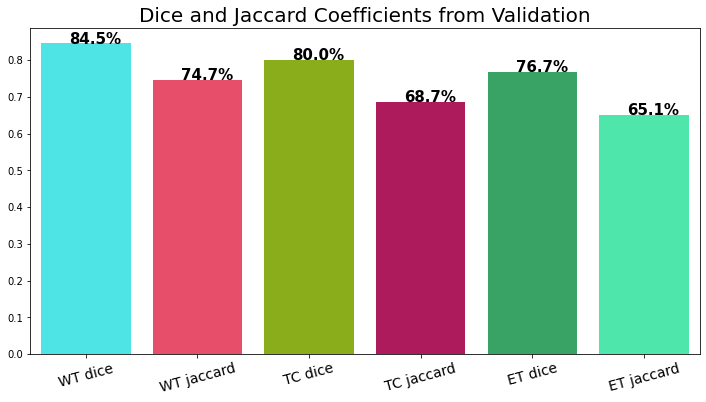

In [51]:
colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF']
palette = sns.color_palette(colors, 6)

fig, ax = plt.subplots(figsize=(12, 6));
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax);
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15);
ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig("result1.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("result1.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

## More visualization

In [52]:
def compute_results(model,
                    dataloader,
                    treshold=0.33):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results = {"Id": [],"image": [], "GT": [],"Prediction": []}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            id_, imgs, targets = data['Id'], data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits)
            
            predictions = (probs >= treshold).float()
            predictions =  predictions.cpu()
            targets = targets.cpu()
            
            results["Id"].append(id_)
            results["image"].append(imgs.cpu())
            results["GT"].append(targets)
            results["Prediction"].append(predictions)
            
            # only 5 pars
            if (i > 5):    
                return results
        return results

In [53]:
%%time
results = compute_results(
    nodel, val_dataloader, 0.33)

CPU times: user 6min 50s, sys: 1min 20s, total: 8min 11s
Wall time: 34.1 s


In [54]:
for id_, img, gt, prediction in zip(results['Id'][4:],
                    results['image'][4:],
                    results['GT'][4:],
                    results['Prediction'][4:]
                    ):
    
    print(id_)
    break

['BraTS20_Training_251']


### convert 3d to 2d ground truth and prediction

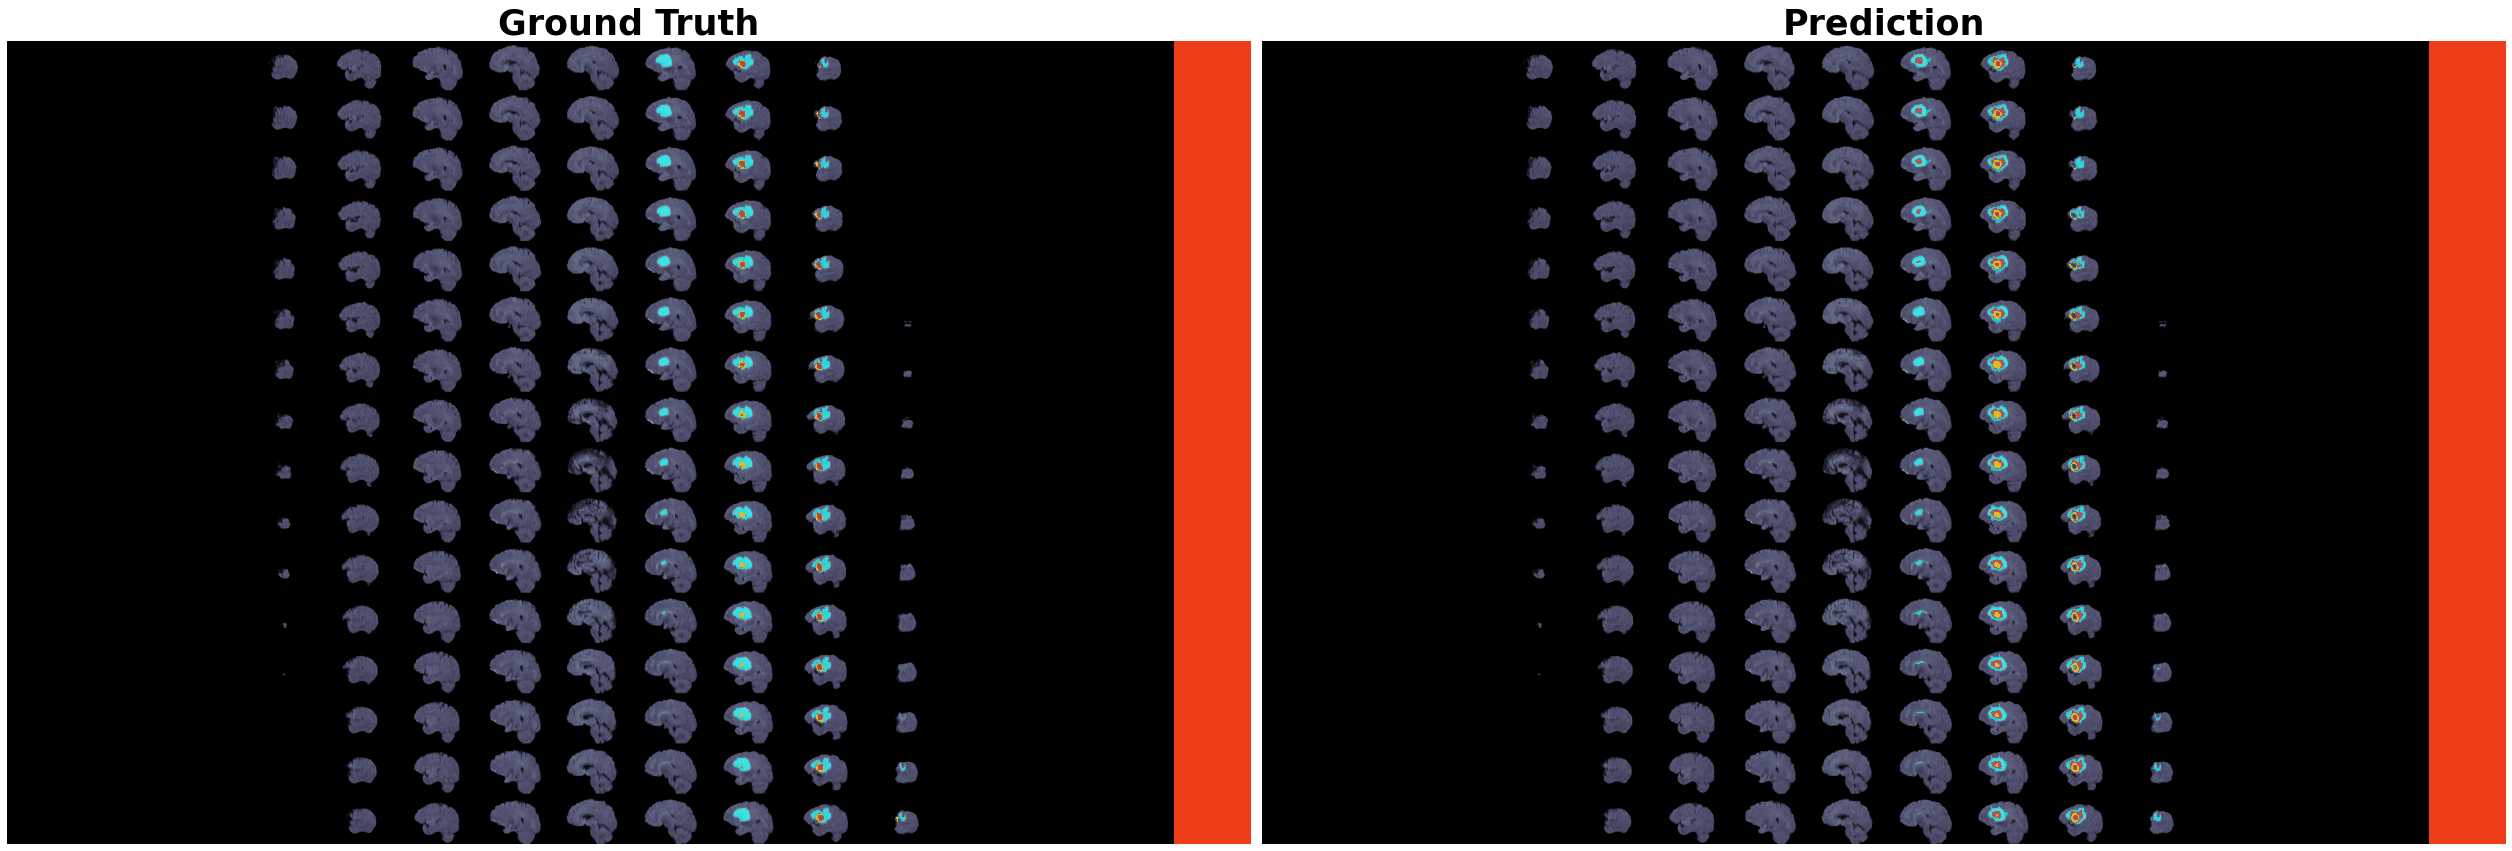

In [55]:
show_result = ShowResult()
show_result.plot(img, gt, prediction)

### 3d binary mask projection for ground truth and prediction

ground truth

In [56]:
gt = gt.squeeze().cpu().detach().numpy()
gt = np.moveaxis(gt, (0, 1, 2, 3), (0, 3, 2, 1))
wt,tc, et = gt
print(wt.shape, tc.shape, et.shape)
gt = (wt + tc + et)
gt = np.clip(gt, 0, 1)
print(gt.shape)

(240, 240, 155) (240, 240, 155) (240, 240, 155)
(240, 240, 155)


In [57]:
%%time
title = "Ground Truth_" + id_[0]
filename1 = title + "_3d.gif"

data_to_3dgif = Image3dToGIF3d(img_dim = (120, 120, 78), binary=True, normalizing=False)
transformed_data = data_to_3dgif.get_transformed_data(gt)
data_to_3dgif.plot_cube(
    transformed_data,
    title=title,
    make_gif=True,
    path_to_save=filename1
)
#show_gif(filename1, format='png')

(120, 120, 78)
binary


100%|██████████| 72/72 [12:50<00:00, 10.70s/it]


CPU times: user 16min 25s, sys: 48.7 s, total: 17min 14s
Wall time: 16min 21s


prediction

In [58]:
prediction = prediction.squeeze().cpu().detach().numpy()
prediction = np.moveaxis(prediction, (0, 1, 2, 3), (0, 3, 2, 1))
wt,tc,et = prediction
print(wt.shape, tc.shape, et.shape)
prediction = (wt + tc + et)
prediction = np.clip(prediction, 0, 1)
print(prediction.shape)

(240, 240, 155) (240, 240, 155) (240, 240, 155)
(240, 240, 155)


In [ ]:
%%time
title = "Prediction_" + id_[0]
filename2 = title + "_3d.gif"

data_to_3dgif = Image3dToGIF3d(img_dim = (120, 120, 78), binary=True, normalizing=False)
transformed_data = data_to_3dgif.get_transformed_data(prediction)
data_to_3dgif.plot_cube(
    transformed_data,
    title=title,
    make_gif=True,
    path_to_save=filename2
)
#show_gif(filename2, format='png')#

(120, 120, 78)
binary


result

In [ ]:
merging_two_gif(filename1,
                filename2, 
                'result.gif')
show_gif('result.gif', format='png')

---------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------

------------------------------------------------------------------------------

------------------------------------------------------------------------------

# 3DAutoEncoder

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv3d(4, 16, 3)
        self.conv2 = nn.Conv3d(16, 32, 3)
        self.conv3 = nn.Conv3d(32, 96, 2)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool2 = nn.MaxPool3d(kernel_size=3, stride=3, return_indices=True)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.enc_linear = nn.Linear(381216, 512)
        
        # Decoder
        self.deconv1 = nn.ConvTranspose3d(96, 32, 2)
        self.deconv2 = nn.ConvTranspose3d(32, 16, 3)
        self.deconv3 = nn.ConvTranspose3d(16, 4, 3)
        self.unpool1 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool2 = nn.MaxUnpool3d(kernel_size=3, stride=3)
        self.unpool3 = nn.MaxUnpool3d(kernel_size=2, stride=2)

        self.dec_linear = nn.Linear(512, 381216)
        
    def encode(self, x, return_partials=True):
        # Encoder
        x = self.conv1(x)
        up3out_shape = x.shape
        x, indices1 = self.pool1(x)
        x = self.conv2(x)
        up2out_shape = x.shape
        x, indices2 = self.pool2(x)
        x = self.conv3(x)
        up1out_shape = x.shape
        x, indices3 = self.pool3(x)
        #print(x.shape)
        x = x.view((x.size(0), -1))
        #print(x.shape)
        x = self.enc_linear(x)

        # required for unpool
        pool_par = {
            "P1": [indices1, up3out_shape], 
            "P2": [indices2, up2out_shape], 
            "P3": [indices3, up1out_shape]
                   }
        
        if return_partials:
            return x, pool_par
        else:
            return x

    def decode(self, x, pool_par):
        x = self.dec_linear(x)
        x = x.view((x.size(0), 96, 11, 19, 19))
        
        x = self.unpool1(x, output_size=pool_par["P3"][1], indices=pool_par["P3"][0])
        #print(x.shape)
        x = self.deconv1(x)
        x = self.unpool2(x, output_size=pool_par["P2"][1], indices=pool_par["P2"][0])
        x = self.deconv2(x)
        x = self.unpool3(x, output_size=pool_par["P1"][1], indices=pool_par["P1"][0])
        x = self.deconv3(x)
        return x
    
    def forward(self, x):
        self.feature, pool_par = self.encode(x)
        out = self.decode(self.feature, pool_par)
        return out

### Dataset and Dataloader

In [ ]:
def get_augmentations(phase):
    list_transforms = []
    
    list_trfms = Compose(list_transforms)
    return list_trfms


def get_dataloader(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    num_workers: int = 4,
):
    '''Returns: dataloader for the model training'''
    df = pd.read_csv(path_to_csv)
    
    train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
    val_df = df.loc[df['fold'] == fold].reset_index(drop=True)

    df = train_df if phase == "train" else val_df
    dataset = dataset(df, phase)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )

    return dataloader

In [ ]:
class AutoEncoderDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str = "test"):
        self.df = df
        self.phase = phase
        self.augmentations = get_augmentations(phase)
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        id_ = self.df.loc[idx, 'Brats20ID']
        root_path = self.df.loc[self.df['Brats20ID'] == id_]['path'].values[0]
        # load all modalities
        images = []
        for data_type in self.data_types:
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)

            img = self.normalize(img)
            images.append(img.astype(np.float32))
        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))
    
        
        return {
            "Id": id_,
            "data": img,
            "label": img,
            }
    
    def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data
    
    def normalize(self, data: np.ndarray,  mean=0.0, std=1.0):
        """Normilize image value between 0 and 1."""
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)
        

In [ ]:
dataloader = get_dataloader(AutoEncoderDataset, 'train_data.csv', phase='valid', fold=0)
len(dataloader)

data = next(iter(dataloader))
data['Id'], data['data'].shape, data['label'].shape

### training process

In [ ]:
class Trainer:
    def __init__(self,
                 net: nn.Module,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 fold: int,
                 num_epochs: int,
                 path_to_csv: str,
                 dataset: torch.utils.data.Dataset,
                ):

        """Initialization."""
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs

        self.dataloaders = {

            phase: get_dataloader(
                dataset = dataset,
                path_to_csv = path_to_csv,
                phase = phase,
                fold = fold,
                batch_size = batch_size,
                num_workers = 4
            )
            for phase in self.phases
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
         
    def _compute_loss_and_outputs(self,
                                  images: torch.Tensor,
                                  targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images)
        loss = self.criterion(logits, targets)
        return loss, logits
        
    def _do_epoch(self, epoch: int, phase: str):
        print(f"{phase} epoch: {epoch} | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == "train" else self.net.eval()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        for itr, data_batch in enumerate(dataloader):
            images, targets = data_batch['data'], data_batch['label']
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches

        
        self.losses[phase].append(epoch_loss)
        print(f"Loss | {self.losses[phase][-1]}")


        return epoch_loss
        
    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
                
            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "autoencoder_best_model.pth")
            print()
        self._save_train_history()
            
            
    def load_predtrain_model(self,
                             state_path: str):
        self.net.load_state_dict(torch.load(state_path), map_location=torch.device('cpu'))
        print("Predtrain model loaded")
        
    def _save_train_history(self):
        """writing model weights and training logs to files."""
        torch.save(self.net.state_dict(),
                   f"autoencoder_last_epoch_model.pth")


In [ ]:
model = AutoEncoder()

trainer = Trainer(net=model,
                  dataset= AutoEncoderDataset,
                  criterion=MSELoss(),
                  lr=5e-4,
                  accumulation_steps=4,
                  batch_size=1,
                  fold=0,
                  num_epochs=1,
                  path_to_csv = config.path_to_csv,)


if config.ae_pretrained_model_path is not None:
    trainer.load_predtrain_model(config.ae_pretrained_model_path)

In [ ]:
%%time
trainer.run()

Checking quality of AE 

In [ ]:
dataloader = get_dataloader(AutoEncoderDataset, 'train_data.csv', phase='val', fold=0)

In [ ]:
model.eval();
with torch.no_grad():
    for data in dataloader:
        id_, imgs, targets = data['Id'], data['data'], data['label']
        imgs, targets = imgs.to('cuda'), targets.to('cuda')
        output = model(imgs)
        output = output.cpu()
        break

ground truth

In [ ]:
imgs = imgs.squeeze().cpu().numpy()
imgs = np.moveaxis(imgs, (0, 1, 2, 3), (0, 3, 2, 1))
print(imgs.shape)

gt_flair, gt_t1, gt_t1ce, gt_t2 = imgs
print(gt_flair.shape, gt_t1.shape, gt_t1ce.shape, gt_t2.shape)

In [ ]:
plt.figure(figsize=(15, 10))
plt.imshow(np.rot90(montage(gt_flair)), cmap='bone')

In [ ]:
%%time
title = "AE_Ground_Truth_" + id_[0]
filename1 = title + "_3d.gif"


data_to_3dgif = Image3dToGIF3d(img_dim = (55, 55, 55), binary=False, normalizing=False)
transformed_data = data_to_3dgif.get_transformed_data(gt_flair)
#transformed_data = np.rot90(transformed_data)
data_to_3dgif.plot_cube(
    transformed_data[:38, :47, :35],
    title=title,
    make_gif=True,
    path_to_save=filename1
)
#show_gif(filename1, format='png')

prediction

In [ ]:
output = output.squeeze().numpy()
output = np.moveaxis(output, (0, 1, 2, 3), (0, 3, 2, 1))
print(output.shape)

pr_flair, pr_t1, pr_t1ce, pr_t2 = output
print(pr_flair.shape, pr_t1.shape, pr_t1ce.shape, pr_t2.shape)

In [ ]:
plt.figure(figsize=(15, 10))
pr_flair1 = pr_flair.copy()
pr_flair1[pr_flair1 < 1e-7] = 0  # remove artifacts.
plt.imshow(np.rot90(montage(pr_flair1)), cmap='bone')

In [ ]:
%%time
title = "AE_Prediction_" + id_[0]
filename2 = title + "_3d.gif"


data_to_3dgif = Image3dToGIF3d(img_dim = (55, 55, 55), binary=False, normalizing=False)
transformed_data = data_to_3dgif.get_transformed_data(pr_flair1)
#transformed_data = np.rot90(transformed_data)
data_to_3dgif.plot_cube(
    transformed_data[:38, :47, :35],
    title=title,
    make_gif=True,
    path_to_save=filename2
)
#show_gif(filename1, format='png')"""

In [ ]:
merging_two_gif(filename1,
                filename2, 
                'AE_result.gif')
show_gif('AE_result.gif', format='png')

Now let's generates all latent features

In [ ]:
class LatentFeaturesGenerator:
    def __init__(self, 
                 autoencoder, 
                 device: str = 'cuda'):
        
        self.autoencoder = autoencoder.to(device)
        self.device = device

    def __call__(self, img):
        with torch.no_grad():
            img = torch.FloatTensor(img).unsqueeze(0).to(self.device)
            latent_features = self.autoencoder.encode(
                img, return_partials=False).squeeze(0).cpu().numpy()

        return latent_features

In [ ]:
class Features_Generator:
    
    def __init__(self, df, autoencoder):
        self.df = df
        self.df_voxel_stats = pd.DataFrame()
        self.latent_feature_generator = LatentFeaturesGenerator(autoencoder)
        
    def _read_file(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj).astype(np.float32)
        return data
    
    def _normalize(self, data: np.ndarray):
        """Normilize image value between 0 and 1."""
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)
    
    def _create_features(self, Brats20ID):
        features = {}
        images = []
        # vOXEL STATS
        for data_type in ['_t1.nii', '_t2.nii', '_flair.nii', '_t1ce.nii']:
            
            
            # data path
            root_path = self.df.loc[self.df['Brats20ID'] == Brats20ID]['path'].values[0]
            file_path = os.path.join(root_path, Brats20ID + data_type)
            
            # flatten 3d array
            img_data = self._read_file(file_path)
            data = img_data.reshape(-1)
            
            # create features
            data_mean = data.mean()
            data_std = data.std()
            intensive_data = data[data > data_mean]
            more_intensive_data = data[data > data_mean + data_std]
            non_intensive_data = data[data < data_mean]
            
            data_skew = stats.skew(data)
            data_kurtosis = stats.kurtosis(data)
            intensive_skew = stats.skew(intensive_data)
            non_intensive_skew = stats.skew(non_intensive_data)
            
            data_diff = np.diff(data)
            
            # write new features in df
            features['Brats20ID'] = Brats20ID
            features[f'{data_type}_skew'] = data_skew,
            features[f'{data_type}_kurtosis'] = data_kurtosis,
            features[f'{data_type}_diff_skew'] = stats.skew(data_diff),
            features[f'{data_type}_intensive_dist'] = intensive_data.shape[0],
            features[f'{data_type}_intensive_skew'] = intensive_skew,
            features[f'{data_type}_non_intensive_dist'] = non_intensive_data.shape[0],
            features[f'{data_type}_non_intensive_skew'] = non_intensive_skew,
            #features[f'{data_type}_intensive_non_intensive_mean_ratio'] = intensive_data.mean() / non_intensive_data.mean(),
            #features[f'{data_type}_intensive_non_intensive_std_ratio'] = intensive_data.std() / non_intensive_data.std(),
            features[f'{data_type}_data_intensive_skew_difference'] = data_skew - intensive_skew,
            features[f'{data_type}_data_non_intensive_skew_difference'] = data_skew - non_intensive_skew,
            features[f'{data_type}_more_intensive_dist'] = more_intensive_data.shape[0],
            
            parts = 15
            for p, part in enumerate(np.array_split(data, parts)):
                features[f'{data_type}_part{p}_mean'] = part.mean()
                
            # Latent Features    
            img = self._normalize(img_data)
            images.append(img.astype(np.float32))
            
        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))
        latent_features = self.latent_feature_generator(img)
        
        for i, lf in enumerate(latent_features):
                features[f'latent_f{i}'] = lf
          
        return pd.DataFrame(features)
    
    
    def run(self):
        
        for _, row in tqdm(self.df.iterrows()):
            ID = row['Brats20ID']
            
            df_features = self._create_features(ID)
            
            self.df_voxel_stats  = pd.concat([self.df_voxel_stats, df_features], axis=0) 
            
        self.df_voxel_stats.reset_index(inplace=True, drop=True) 
        self.df_voxel_stats = self.df_voxel_stats.merge(self.df[['Brats20ID', 'Age', 'Survival_days']], on='Brats20ID', how='left')
            

In [ ]:
%%time
model.eval();
fg =  Features_Generator(df, model)
fg.run()
fg.df_voxel_stats.to_csv("df_with_voxel_stats_and_latent_features.csv", index=False)
fg.df_voxel_stats

Now that we have tabular data, we can use it to predict age and survival days.
we will use SVR for this purpose.

In [ ]:
df = pd.read_csv("df_with_voxel_stats_and_latent_features.csv")#

df['is_train'] = 0
df['is_train'].loc[df['Survival_days'].notnull()] = 1

df['SD'] = df['Survival_days'].str.extract(r'(\d+[.\d]*)')
df['SD'] = df['SD'].astype("float64")
df['Age'] = df['Age'].astype("float64")
df.sample(5)

In [ ]:
test_df = df[df["is_train"] != True].copy()
df = df[df["is_train"] == True].copy()
print("train ->", df.shape, "test ->", test_df.shape)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(df['Age'].apply(lambda x: np.round(x, 0)), ax=ax, palette='Dark2')

ax.set_xticks(ax.get_xticks()[::2]);
ax.set_ylabel('number of unique (rounded) ages', fontsize=20)
ax.set_xlabel('unique (rounded) ages', fontsize=20)
ax.set_title("Distribution of rounded Ages in data", fontsize=25, y=1.05, fontweight='bold');

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
k = 10
sns.countplot(df['SD'].apply(lambda x: int(k * round(float(x)/k))), ax=ax, palette='Dark2')#base * round(float(x)/base)

ax.set_xticks(ax.get_xticks()[::2]);
ax.set_ylabel('number of unique (rounding to the nearest {k}) Survival_days', fontsize=15)
ax.set_xlabel(f'unique (rounding to the nearest {k}) Survival_days', fontsize=17)
ax.set_title("Distribution of rounded Survival_days in data", fontsize=25, y=1.05, fontweight='bold');

In [ ]:
def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))

In [ ]:
%%time
NUM_FOLDS = 7
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=config.seed)


features = list(df.columns[1:-4])

overal_score = 0
for target, c, w in [("Age", 100, 0.5), ("SD", 5, 0.5)]:    
    y_oof = np.zeros(df.shape[0])
    y_test = np.zeros((test_df.shape[0], NUM_FOLDS))
    
    for f, (train_ind, val_ind) in enumerate(kf.split(df, df)):
        train_df, val_df = df.iloc[train_ind], df.iloc[val_ind]
        train_df = train_df[train_df[target].notnull()]

        model = SVR(C=c, cache_size=3000.0)
        model.fit(train_df[features], train_df[target])

        y_oof[val_ind] = model.predict(val_df[features])
        y_test[:, f] = model.predict(test_df[features])
        
    df["pred_{}".format(target)] = y_oof
    test_df[target] = y_test.mean(axis=1)
    score = metric(df[df[target].notnull()][target].values, df[df[target].notnull()]["pred_{}".format(target)].values)
    overal_score += w*score
    print(target, np.round(score, 4))
    print()
    
print("Overal score:", np.round(overal_score, 4))